# ROMY vs. ADR Similarity Analysis

In [1]:
import os, sys
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from andbro__read_sds import __read_sds

In [31]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'teide':
    root_path = '/home/sysopromy/'
    data_path = '/freenas-ffb-01/'
    archive_path = '/freenas-ffb-01/'
    bay_path = '/bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [36]:
sys.argv

['/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/ipykernel_launcher.py',
 '--f=/home/andbro/.local/share/jupyter/runtime/kernel-v3d1cefe979d132b1b83d2ee43daa4d45fe64df782.json']

In [37]:
config = {}

# output path for figures
config['path_to_figs'] = archive_path+f"romy_html_monitor/figures/"

# seed IDs for ROMY and ADR
config['romy_seeds'] = ['BW.ROMY.00.BJZ', 'BW.ROMY.00.BJN', 'BW.ROMY.00.BJE']
config['adr_seeds'] = ['BW.ROMY.22.BJZ', 'BW.ROMY.22.BJN', 'BW.ROMY.22.BJE']

# path to data archive
config['path_to_data'] = data_path+"romy_events/data/"

# path to data sds
config['path_to_sds'] = archive_path+"temp_archive/"

# time range for loading data
if len(sys.argv) > 2:
    config['tbeg'] = obs.UTCDateTime(sys.argv[1])
    config['tend'] = obs.UTCDateTime(sys.argv[1]) + 86400
else:
    config['tbeg'] = obs.UTCDateTime("2025-05-28 00:00")
    config['tend'] = obs.UTCDateTime("2025-05-28 01:00")

# frequency band for filtering
config['fmin'] = 0.1 # Hz
config['fmax'] = 0.5 # Hz

# window length and overlap for cross-correlation analysis
config['twin'] = 900 # seconds
config['overlap'] = 0.5 # % overlap

# time scale for the x-axis of the plot
config['time_unit'] = 'hours' # 'minutes', 'seconds', 'hours', 'days'


## Load Data

### Load Waveform Data


In [7]:
st0 = obs.Stream()

try:

    for seed in config['romy_seeds']:
        print(f"loading {seed} ...")
        st0 += __read_sds(config['path_to_sds'], seed, config['tbeg'], config['tend'])

    for seed in config['adr_seeds']:
        print(f"loading {seed} ...")
        st0 += __read_sds(config['path_to_sds'], seed, config['tbeg'], config['tend'])

    st0.merge(fill_value="interpolate")

except Exception as e:
    print(e)
    sys.exit()

st0

loading BW.ROMY.00.BJZ ...
loading BW.ROMY.00.BJN ...
loading BW.ROMY.00.BJE ...
loading BW.ROMY.22.BJZ ...
loading BW.ROMY.22.BJN ...
loading BW.ROMY.22.BJE ...


6 Trace(s) in Stream:
BW.ROMY.00.BJE | 2025-05-28T00:00:00.000000Z - 2025-05-28T01:00:00.000000Z | 20.0 Hz, 72001 samples
BW.ROMY.00.BJN | 2025-05-28T00:00:00.000000Z - 2025-05-28T01:00:00.000000Z | 20.0 Hz, 72001 samples
BW.ROMY.00.BJZ | 2025-05-28T00:00:00.000000Z - 2025-05-28T01:00:00.000000Z | 20.0 Hz, 72001 samples
BW.ROMY.22.BJE | 2025-05-28T00:00:00.039999Z - 2025-05-28T00:59:59.989999Z | 20.0 Hz, 72000 samples
BW.ROMY.22.BJN | 2025-05-28T00:00:00.040000Z - 2025-05-28T00:59:59.990000Z | 20.0 Hz, 72000 samples
BW.ROMY.22.BJZ | 2025-05-28T00:00:00.040000Z - 2025-05-28T00:59:59.990000Z | 20.0 Hz, 72000 samples

### Processing Data

In [9]:
# correct amplitude of ROMY data if location is 00
for tr in st0:
    if tr.stats.location == "00":
        tr.data = tr.data * 0.75

In [10]:
def __trim_stream(st0, set_common=True, set_interpolate=False):
    '''
    Trim a stream to common start and end times (and interpolate to common times)
    '''

    from numpy import interp, arange

    def __get_size(st0):
        return [tr.stats.npts for tr in st0]

    # get size of traces
    n_samples = __get_size(st0)

    # check if all traces have same amount of samples
    if not all(x == n_samples[0] for x in n_samples):
        print(f" -> stream size inconsistent: {n_samples}")

        # if difference not larger than one -> adjust
        if any([abs(x-n_samples[0]) > 1 for x in n_samples]):

            # set to common minimum interval
            if set_common:
                _tbeg = max([tr.stats.starttime for tr in st0])
                _tend = min([tr.stats.endtime for tr in st0])
                st0 = st0.trim(_tbeg, _tend, nearest_sample=True)
                print(f"  -> adjusted: {__get_size(st0)}")

                if set_interpolate:
                    _times = arange(0, min(__get_size(st0)), st[0].stats.delta)
                    for tr in st0:
                        tr.data = interp(_times, tr.times(reftime=_tbeg), tr.data)
        else:
            # adjust for difference of one sample
            for tr in st0:
                tr.data = tr.data[:min(n_samples)]
            print(f"  -> adjusted: {__get_size(st0)}")

    return st0

In [11]:
st0 = __trim_stream(st0)

 -> stream size inconsistent: [72001, 72001, 72001, 72000, 72000, 72000]
  -> adjusted: [72000, 72000, 72000, 72000, 72000, 72000]


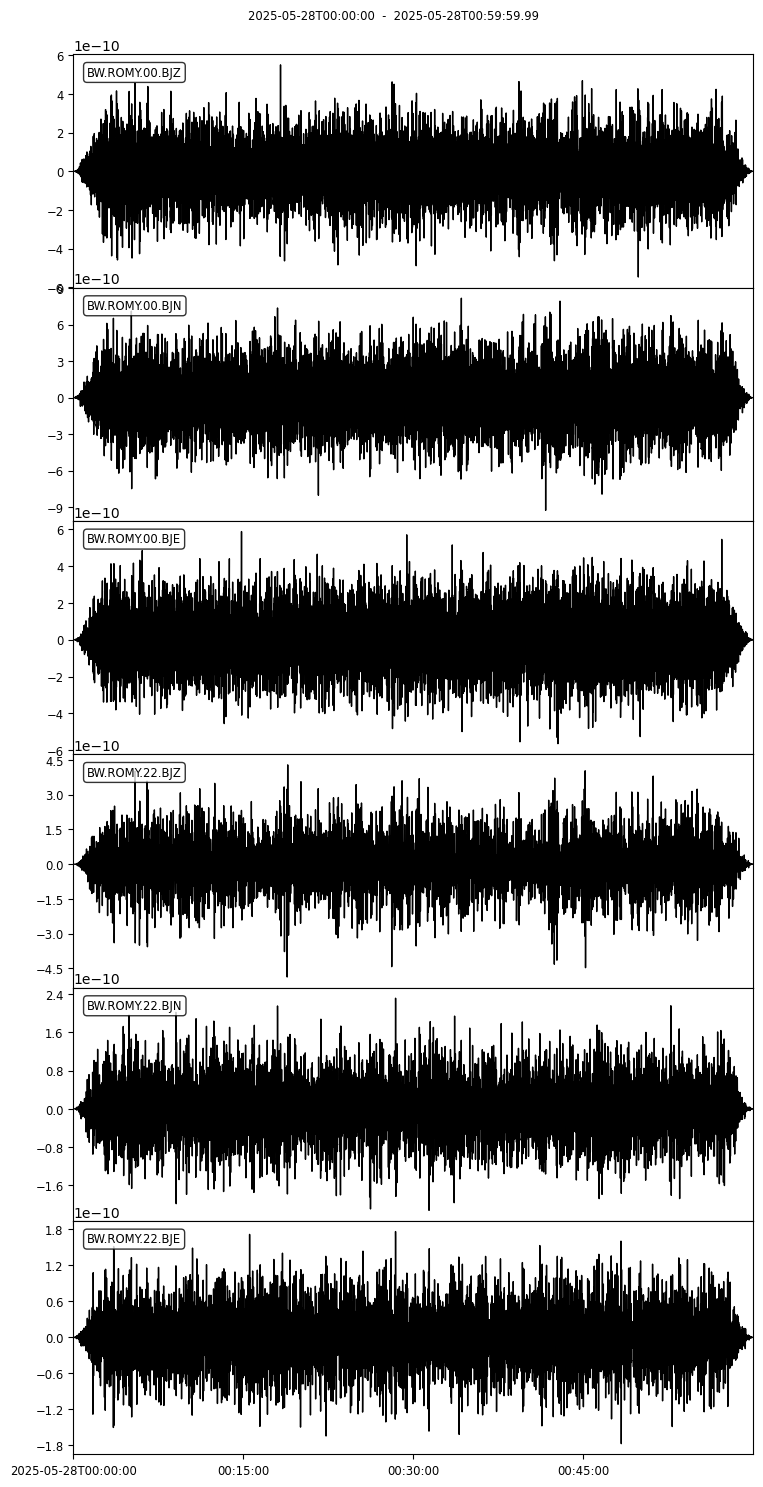

In [ ]:
st = st0.copy()

st = st.detrend("demean")
st = st.detrend("linear")
st = st.taper(max_percentage=0.05)
st = st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

# st.plot(equal_scale=False);

### Plotting

In [ ]:
def __compute_windowed_cross_correlation_analysis(st, seeds_loc1, seeds_loc2, twin=60, 
                                                 overlap=0.5, location_labels=None, tunit='minutes', fmin=None, fmax=None):
    """
    Compute windowed cross-correlation and coherence analysis between matching channels 
    from different locations.
    
    Parameters:
    -----------
    st : obspy.Stream
        Input stream containing channels from both locations
    seeds_loc1 : list
        List of seed IDs for first location (e.g., location 22)
    seeds_loc2 : list
        List of seed IDs for second location (e.g., location 00)
    twin : float
        Window length in seconds
    overlap : float
        Overlap fraction (0.0 to 1.0)
    location_labels : list or None
        Labels for the two locations [loc1_label, loc2_label]
    tunit : str
        Time scale for the x-axis of the plot ('minutes' or 'seconds')
    fmin : float
        Minimum frequency for the bandpass filter
    fmax : float
        Maximum frequency for the bandpass filter
        
    Returns:
    --------
    results : dict
        Dictionary containing analysis results for each channel pair
    fig : matplotlib figure
        Figure showing time series of cross-correlation metrics
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import signal
    from matplotlib.gridspec import GridSpec
    
    # tscale to seconds
    if tunit == 'minutes':
        tscale = 60
    elif tunit == 'hours':
        tscale = 3600
    elif tunit == 'days':
        tscale = 86400
    elif tunit == 'seconds':
        tscale = 1
    else:
        raise ValueError(f"Invalid time scale: {tunit}")

    # Set default labels
    if location_labels is None:
        location_labels = ['Location 1', 'Location 2']
    
    # Find matching channel pairs
    channel_pairs = []
    for seed1 in seeds_loc1:
        # Extract channel code (last 3 characters, e.g., 'BJZ')
        channel_code1 = seed1.split('.')[-1]
        
        for seed2 in seeds_loc2:
            channel_code2 = seed2.split('.')[-1]
            
            if channel_code1 == channel_code2:
                channel_pairs.append((seed1, seed2, channel_code1))
                break
    
    if not channel_pairs:
        print("No matching channel pairs found")
        return None, None
    
    # Get sampling parameters
    dt = st[0].stats.delta  # sampling interval in seconds
    fs = st[0].stats.sampling_rate  # sampling rate in Hz
    
    # Convert window time to samples
    nwin = int(twin / dt)  # number of samples in window
    hop_length = int(nwin * (1 - overlap))
    
    # Get data length and check if window is feasible
    data_length = len(st[0].data)
    data_duration = data_length * dt
    
    print(f"Data info: {data_length} samples, {data_duration:.1f} seconds")
    print(f"Window parameters: {twin} s = {nwin} samples, overlap = {overlap*100:.0f}%")
    
    if nwin >= data_length:
        # Suggest a reasonable window size
        suggested_twin = int(data_duration / 4)  # Use 1/4 of data length
        suggested_nwin = int(suggested_twin / dt)
        print(f"ERROR: Window too large! Window ({nwin} samples) >= Data ({data_length} samples)")
        print(f"Suggested window size: {suggested_twin} seconds ({suggested_nwin} samples)")
        return None, None
    
    n_windows = (data_length - nwin) // hop_length + 1
    
    if n_windows < 2:
        print(f"ERROR: Not enough data for windowed analysis. Only {n_windows} window(s) possible.")
        print(f"Try smaller window size or more data.")
        return None, None
    
    print(f"Analysis will use {n_windows} windows")
    
    # Initialize results dictionary
    results = {}
    
    # Time array for windows (center time of each window)
    window_times = []
    start_time = st[0].stats.starttime
    
    for i in range(n_windows):
        window_start_sample = i * hop_length
        window_center_sample = window_start_sample + nwin // 2
        window_center_time = start_time + window_center_sample * dt
        window_times.append(window_center_time)
    
    window_times = np.array(window_times)
    
    # Process each channel pair
    for seed1, seed2, channel_code in channel_pairs:
        print(f"Processing {channel_code}: {seed1} vs {seed2}")
        
        try:
            # Get data
            data1 = st.select(id=seed1)[0].data
            data2 = st.select(id=seed2)[0].data
            
            # Check data length consistency
            if len(data1) != len(data2):
                print(f"Warning: Data length mismatch for {channel_code}")
                min_len = min(len(data1), len(data2))
                data1 = data1[:min_len]
                data2 = data2[:min_len]
            
            # Initialize arrays for this channel
            zero_lag_cc = []
            max_cc = []
            max_cc_lag = []
            median_coherence = []
            percentile95_coherence = []
            max_coherence = []
            
            # Process each window
            for i in range(n_windows):
                window_start = i * hop_length
                window_end = window_start + nwin
                
                # Check bounds
                if window_end > len(data1):
                    break
                
                # Extract windowed data
                win_data1 = data1[window_start:window_end]
                win_data2 = data2[window_start:window_end]
                
                # Skip if window contains NaN or not enough data
                if (len(win_data1) < nwin or len(win_data2) < nwin or 
                    np.any(~np.isfinite(win_data1)) or np.any(~np.isfinite(win_data2))):
                    zero_lag_cc.append(np.nan)
                    max_cc.append(np.nan)
                    max_cc_lag.append(np.nan)
                    median_coherence.append(np.nan)
                    percentile95_coherence.append(np.nan)
                    max_coherence.append(np.nan)
                    continue
                
                # Remove mean (detrend)
                win_data1 = win_data1 - np.mean(win_data1)
                win_data2 = win_data2 - np.mean(win_data2)
                
                # Compute zero-lag cross-correlation (normalized)
                try:
                    # Check for zero variance
                    if np.std(win_data1) == 0 or np.std(win_data2) == 0:
                        zero_lag_cc.append(np.nan)
                    else:
                        corr_coeff = np.corrcoef(win_data1, win_data2)[0, 1]
                        zero_lag_cc.append(corr_coeff)
                except:
                    zero_lag_cc.append(np.nan)
                
                # Compute full cross-correlation function
                try:
                    correlation = signal.correlate(win_data1, win_data2, mode='full')
                    # Normalize
                    norm = np.sqrt(np.sum(win_data1**2) * np.sum(win_data2**2))
                    if norm > 0:
                        correlation = correlation / norm
                    
                    # Find maximum correlation and its lag
                    max_idx = np.argmax(np.abs(correlation))
                    max_corr_val = correlation[max_idx]
                    # Lag in samples (negative means data2 leads data1)
                    lag_samples = max_idx - (len(correlation) - 1) // 2
                    lag_time = lag_samples * dt  # Convert to time
                    
                    max_cc.append(max_corr_val)
                    max_cc_lag.append(lag_time)
                except:
                    max_cc.append(np.nan)
                    max_cc_lag.append(np.nan)
                
                # Compute coherence
                try:
                    # Use a smaller nperseg for coherence to avoid issues with short windows
                    nperseg = min(nwin//4, 256, nwin)
                    if nperseg < 8:  # Minimum for coherence calculation
                        median_coherence.append(np.nan)
                        percentile95_coherence.append(np.nan)
                        max_coherence.append(np.nan)
                    else:
                        f, Cxy = signal.coherence(win_data1, win_data2, fs=fs, 
                                                nperseg=nperseg)
                        # Compute median, 95th percentile, and max coherence
                        median_coh = np.median(Cxy)
                        percentile95_coh = np.percentile(Cxy, 95)
                        max_coh = np.max(Cxy)
                        
                        median_coherence.append(median_coh)
                        percentile95_coherence.append(percentile95_coh)
                        max_coherence.append(max_coh)
                except:
                    median_coherence.append(np.nan)
                    percentile95_coherence.append(np.nan)
                    max_coherence.append(np.nan)
            
            # Store results (trim arrays to actual number of processed windows)
            actual_windows = len(zero_lag_cc)
            results[channel_code] = {
                'seed1': seed1,
                'seed2': seed2,
                'window_times': window_times[:actual_windows],
                'zero_lag_cc': np.array(zero_lag_cc),
                'max_cc': np.array(max_cc),
                'max_cc_lag': np.array(max_cc_lag),
                'median_coherence': np.array(median_coherence),
                'percentile95_coherence': np.array(percentile95_coherence),
                'max_coherence': np.array(max_coherence)
            }
            
        except IndexError:
            print(f"Data not found for channel pair {channel_code}")
            continue
        except Exception as e:
            print(f"Error processing {channel_code}: {str(e)}")
            continue
    
    # Create visualization
    n_channels = len(results)
    if n_channels == 0:
        print("No successful channel processing")
        return results, None
    
    # Set up figure with 3 columns
    fig = plt.figure(figsize=(15, 4 * n_channels))
    gs = GridSpec(n_channels, 3, figure=fig, wspace=0.3, hspace=0.4)
    
    # Plot results for each channel
    for i, (channel_code, data) in enumerate(results.items()):
        
        # Convert this channel's window times to minutes
        channel_time_minutes = [(t - data['window_times'][0]) / tscale for t in data['window_times']]
        
        # Combined cross-correlation plot (zero-lag + max)
        ax1 = fig.add_subplot(gs[i, 0])
        ax1.plot(channel_time_minutes, data['zero_lag_cc'], 'b-', linewidth=1.5, label='Zero-lag CC', zorder=3)
        ax1.plot(channel_time_minutes, data['max_cc'], 'r--', linewidth=1.5, label='Max CC', zorder=2)
        ax1.set_ylabel('Cross-correlation')
        ax1.set_title(f'{channel_code}\nCross-correlation')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(-1, 1)
        ax1.axhline(0, color='k', linestyle='-', alpha=0.3)
        ax1.legend(loc='upper right', fontsize=9)
        
        # Time lag of maximum correlation
        ax2 = fig.add_subplot(gs[i, 1])
        ax2.plot(channel_time_minutes, data['max_cc_lag'], 'r-', linewidth=1.5)
        ax2.set_ylabel('Lag (s)')
        ax2.set_title(f'{channel_code}\nTime Lag of Max CC')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(0, color='k', linestyle='-', alpha=0.3)
        
        # Coherence (median, 95th percentile, max)
        ax3 = fig.add_subplot(gs[i, 2])
        ax3.plot(channel_time_minutes, data['median_coherence'], 'm-', linewidth=1.5, label='Median')
        ax3.plot(channel_time_minutes, data['percentile95_coherence'], 'c-', linewidth=1.5, label='95th percentile')
        ax3.plot(channel_time_minutes, data['max_coherence'], 'k-', linewidth=1.5, label='Maximum')
        ax3.set_ylabel('Coherence')
        ax3.set_title(f'{channel_code}\nCoherence Statistics')
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim(0, 1)
        ax3.axhline(0.5, color='k', linestyle='--', alpha=0.5)
        ax3.legend(loc='upper right', fontsize=9)
        
        # Add x-labels only to bottom row
        if i == n_channels - 1:
            ax1.set_xlabel(f'Time ({tunit})')
            ax2.set_xlabel(f'Time ({tunit})')
            ax3.set_xlabel(f'Time ({tunit})')
    
    # Add overall title
    start_time_str = str(window_times[0]).split('.')[0]
    end_time_str = str(window_times[-1]).split('.')[0]
    title = f'Windowed Cross-correlation Analysis: {location_labels[0]} vs {location_labels[1]}\n'
    title += f'{start_time_str} to {end_time_str} \n'
    title += f'fmin: {fmin} - {fmax} Hz, Window: {twin}s ({nwin} samples), Overlap: {overlap*100:.0f}%'
    
    plt.suptitle(title, fontsize=14)
    # plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return results, fig

Data info: 72000 samples, 3600.0 seconds
Window parameters: 300 s = 6000 samples, overlap = 75%
Analysis will use 45 windows
Processing BJZ: BW.ROMY.00.BJZ vs BW.ROMY.22.BJZ
Processing BJN: BW.ROMY.00.BJN vs BW.ROMY.22.BJN
Processing BJE: BW.ROMY.00.BJE vs BW.ROMY.22.BJE


/tmp/ipykernel_97015/2289239393.py:291: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


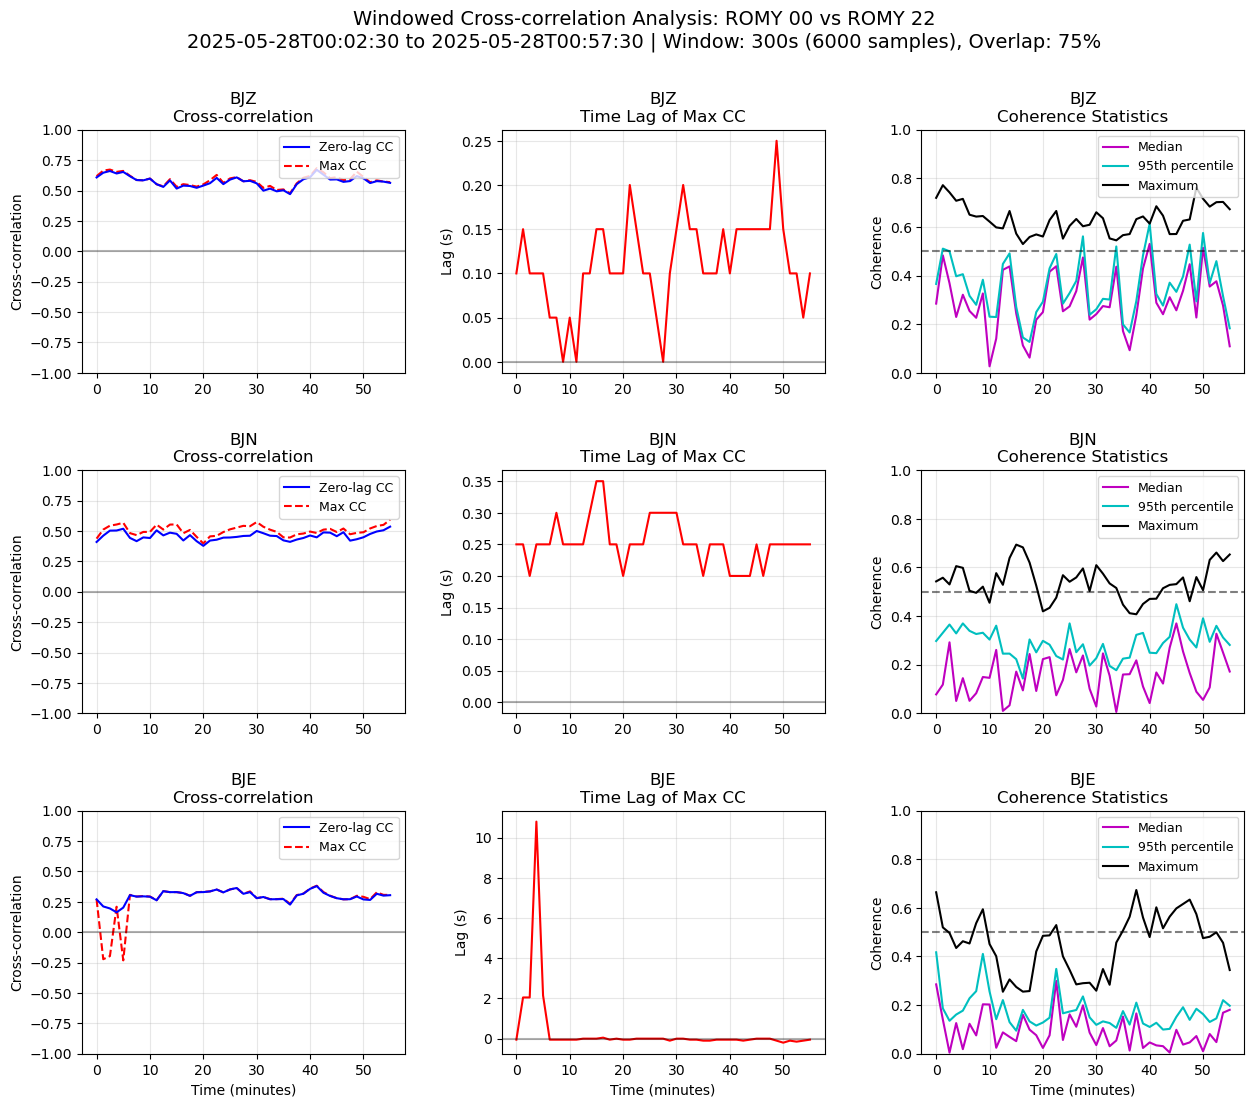

In [ ]:
results, fig_timeseries = __compute_windowed_cross_correlation_analysis(
    st, 
    config['romy_seeds'], 
    config['adr_seeds'],
    twin=config['twin'],  # seconds
    overlap=config['overlap'],  # % overlap
    location_labels=['BW.ROMY.00', 'BW.ROMY.22'],
    tunit=config['time_unit'],
    fmin=config['fmin'],
    fmax=config['fmax']
)

fig_timeseries.savefig(config['path_to_figs']+"makeplot_romy_adr_test.png")

In [28]:
def __compute_windowed_cross_correlation_analysis(st, seeds_loc1, seeds_loc2, twin=60, 
                                                 overlap=0.5, location_labels=None, tunit='minutes', fmin=None, fmax=None):
    """
    Compute windowed cross-correlation and coherence analysis between matching channels 
    from different locations.
    
    Parameters:
    -----------
    st : obspy.Stream
        Input stream containing channels from both locations
    seeds_loc1 : list
        List of seed IDs for first location (e.g., location 22)
    seeds_loc2 : list
        List of seed IDs for second location (e.g., location 00)
    twin : float
        Window length in seconds
    overlap : float
        Overlap fraction (0.0 to 1.0)
    location_labels : list or None
        Labels for the two locations [loc1_label, loc2_label]
    tunit : str
        Time scale for the x-axis of the plot ('minutes' or 'seconds')
    fmin : float
        Minimum frequency for the bandpass filter
    fmax : float
        Maximum frequency for the bandpass filter
        
    Returns:
    --------
    results : dict
        Dictionary containing analysis results for each channel pair
    fig : matplotlib figure
        Figure showing time series of cross-correlation metrics
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy import signal
    from matplotlib.gridspec import GridSpec
    
    # tscale to seconds
    if tunit == 'minutes':
        tscale = 60
    elif tunit == 'hours':
        tscale = 3600
    elif tunit == 'days':
        tscale = 86400
    elif tunit == 'seconds':
        tscale = 1
    else:
        raise ValueError(f"Invalid time scale: {tunit}")

    # Set default labels
    if location_labels is None:
        location_labels = ['Location 1', 'Location 2']
    
    # Find matching channel pairs
    channel_pairs = []
    for seed1 in seeds_loc1:
        # Extract channel code (last 3 characters, e.g., 'BJZ')
        channel_code1 = seed1.split('.')[-1]
        
        for seed2 in seeds_loc2:
            channel_code2 = seed2.split('.')[-1]
            
            if channel_code1 == channel_code2:
                channel_pairs.append((seed1, seed2, channel_code1))
                break
    
    if not channel_pairs:
        print("No matching channel pairs found")
        return None, None
    
    # Get sampling parameters
    dt = st[0].stats.delta  # sampling interval in seconds
    fs = st[0].stats.sampling_rate  # sampling rate in Hz
    
    # Convert window time to samples
    nwin = int(twin / dt)  # number of samples in window
    hop_length = int(nwin * (1 - overlap))
    
    # Get data length and check if window is feasible
    data_length = len(st[0].data)
    data_duration = data_length * dt
    
    print(f"Data info: {data_length} samples, {data_duration:.1f} seconds")
    print(f"Window parameters: {twin} s = {nwin} samples, overlap = {overlap*100:.0f}%")
    
    if nwin >= data_length:
        # Suggest a reasonable window size
        suggested_twin = int(data_duration / 4)  # Use 1/4 of data length
        suggested_nwin = int(suggested_twin / dt)
        print(f"ERROR: Window too large! Window ({nwin} samples) >= Data ({data_length} samples)")
        print(f"Suggested window size: {suggested_twin} seconds ({suggested_nwin} samples)")
        return None, None
    
    n_windows = (data_length - nwin) // hop_length + 1
    
    if n_windows < 2:
        print(f"ERROR: Not enough data for windowed analysis. Only {n_windows} window(s) possible.")
        print(f"Try smaller window size or more data.")
        return None, None
    
    print(f"Analysis will use {n_windows} windows")
    
    # Initialize results dictionary
    results = {}
    
    # Time array for windows (center time of each window)
    window_times = []
    start_time = st[0].stats.starttime
    
    for i in range(n_windows):
        window_start_sample = i * hop_length
        window_center_sample = window_start_sample + nwin // 2
        window_center_time = start_time + window_center_sample * dt
        window_times.append(window_center_time)
    
    window_times = np.array(window_times)
    
    # Process each channel pair
    for seed1, seed2, channel_code in channel_pairs:
        print(f"Processing {channel_code}: {seed1} vs {seed2}")
        
        try:
            # Get data
            data1 = st.select(id=seed1)[0].data
            data2 = st.select(id=seed2)[0].data
            
            # Check data length consistency
            if len(data1) != len(data2):
                print(f"Warning: Data length mismatch for {channel_code}")
                min_len = min(len(data1), len(data2))
                data1 = data1[:min_len]
                data2 = data2[:min_len]
            
            # Initialize arrays for this channel
            zero_lag_cc = []
            median_coherence = []
            percentile95_coherence = []
            max_coherence = []
            
            # Process each window
            for i in range(n_windows):
                window_start = i * hop_length
                window_end = window_start + nwin
                
                # Check bounds
                if window_end > len(data1):
                    break
                
                # Extract windowed data
                win_data1 = data1[window_start:window_end]
                win_data2 = data2[window_start:window_end]
                
                # Skip if window contains NaN or not enough data
                if (len(win_data1) < nwin or len(win_data2) < nwin or 
                    np.any(~np.isfinite(win_data1)) or np.any(~np.isfinite(win_data2))):
                    zero_lag_cc.append(np.nan)
                    median_coherence.append(np.nan)
                    percentile95_coherence.append(np.nan)
                    max_coherence.append(np.nan)
                    continue
                
                # Remove mean (detrend)
                win_data1 = win_data1 - np.mean(win_data1)
                win_data2 = win_data2 - np.mean(win_data2)
                
                # Compute zero-lag cross-correlation (normalized)
                try:
                    # Check for zero variance
                    if np.std(win_data1) == 0 or np.std(win_data2) == 0:
                        zero_lag_cc.append(np.nan)
                    else:
                        corr_coeff = np.corrcoef(win_data1, win_data2)[0, 1]
                        zero_lag_cc.append(corr_coeff)
                except:
                    zero_lag_cc.append(np.nan)
                
                # Compute coherence
                try:
                    # Use a smaller nperseg for coherence to avoid issues with short windows
                    nperseg = min(nwin//4, 256, nwin)
                    if nperseg < 8:  # Minimum for coherence calculation
                        median_coherence.append(np.nan)
                        percentile95_coherence.append(np.nan)
                        max_coherence.append(np.nan)
                    else:
                        f, Cxy = signal.coherence(win_data1, win_data2, fs=fs, 
                                                nperseg=nperseg)
                        # Compute median, 95th percentile, and max coherence
                        median_coh = np.median(Cxy)
                        percentile95_coh = np.percentile(Cxy, 95)
                        max_coh = np.max(Cxy)
                        
                        median_coherence.append(median_coh)
                        percentile95_coherence.append(percentile95_coh)
                        max_coherence.append(max_coh)
                except:
                    median_coherence.append(np.nan)
                    percentile95_coherence.append(np.nan)
                    max_coherence.append(np.nan)
            
            # Store results (trim arrays to actual number of processed windows)
            actual_windows = len(zero_lag_cc)
            results[channel_code] = {
                'seed1': seed1,
                'seed2': seed2,
                'window_times': window_times[:actual_windows],
                'zero_lag_cc': np.array(zero_lag_cc),
                'median_coherence': np.array(median_coherence),
                'percentile95_coherence': np.array(percentile95_coherence),
                'max_coherence': np.array(max_coherence)
            }
            
        except IndexError:
            print(f"Data not found for channel pair {channel_code}")
            continue
        except Exception as e:
            print(f"Error processing {channel_code}: {str(e)}")
            continue
    
    # Create visualization
    n_channels = len(results)
    if n_channels == 0:
        print("No successful channel processing")
        return results, None
    
    # Set up figure with 2 columns
    fig = plt.figure(figsize=(12, 4 * n_channels))
    gs = GridSpec(n_channels, 2, figure=fig, wspace=0.15, hspace=0.2)
    
    # Plot results for each channel
    for i, (channel_code, data) in enumerate(results.items()):
        
        # Convert this channel's window times to minutes
        channel_time_minutes = [(t - data['window_times'][0]) / tscale for t in data['window_times']]
        
        # Zero-lag cross-correlation plot
        ax1 = fig.add_subplot(gs[i, 0])
        ax1.plot(channel_time_minutes, data['zero_lag_cc'], 'b-', linewidth=1.5, label='Zero-lag CC')
        ax1.set_ylabel('Cross-correlation')
        ax1.set_title(f'{channel_code}:  Zero-lag Cross-correlation')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(-1, 1)
        ax1.axhline(0, color='k', linestyle='-', alpha=0.3)
        
        # Coherence (median, 95th percentile, max)
        ax2 = fig.add_subplot(gs[i, 1])
        ax2.plot(channel_time_minutes, data['median_coherence'], 'm-', linewidth=1.5, label='Median')
        ax2.plot(channel_time_minutes, data['percentile95_coherence'], 'c-', linewidth=1.5, label='95th percentile')
        ax2.plot(channel_time_minutes, data['max_coherence'], 'k-', linewidth=1.5, label='Maximum')
        ax2.set_ylabel('Coherence')
        ax2.set_title(f'{channel_code}:  Coherence Statistics')
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 1)
        ax2.axhline(0.5, color='k', linestyle='--', alpha=0.5)
        ax2.legend(loc='upper right', fontsize=9)
        
        # Add x-labels only to bottom row
        if i == n_channels - 1:
            ax1.set_xlabel(f'Time ({tunit})')
            ax2.set_xlabel(f'Time ({tunit})')
    
    # Add overall title
    start_time_str = str(window_times[0]).split('.')[0]
    end_time_str = str(window_times[-1]).split('.')[0]
    title = f'Windowed Cross-correlation Analysis: {location_labels[0]} vs {location_labels[1]}\n'
    title += f'{start_time_str} to {end_time_str} \n'
    title += f'fmin: {fmin} - {fmax} Hz, Window: {twin}s ({nwin} samples), Overlap: {overlap*100:.0f}%'
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    
    return results, fig

Data info: 72000 samples, 3600.0 seconds
Window parameters: 900 s = 18000 samples, overlap = 50%
Analysis will use 7 windows
Processing BJZ: BW.ROMY.00.BJZ vs BW.ROMY.22.BJZ
Processing BJN: BW.ROMY.00.BJN vs BW.ROMY.22.BJN
Processing BJE: BW.ROMY.00.BJE vs BW.ROMY.22.BJE


/tmp/ipykernel_97015/2155582656.py:272: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.94])


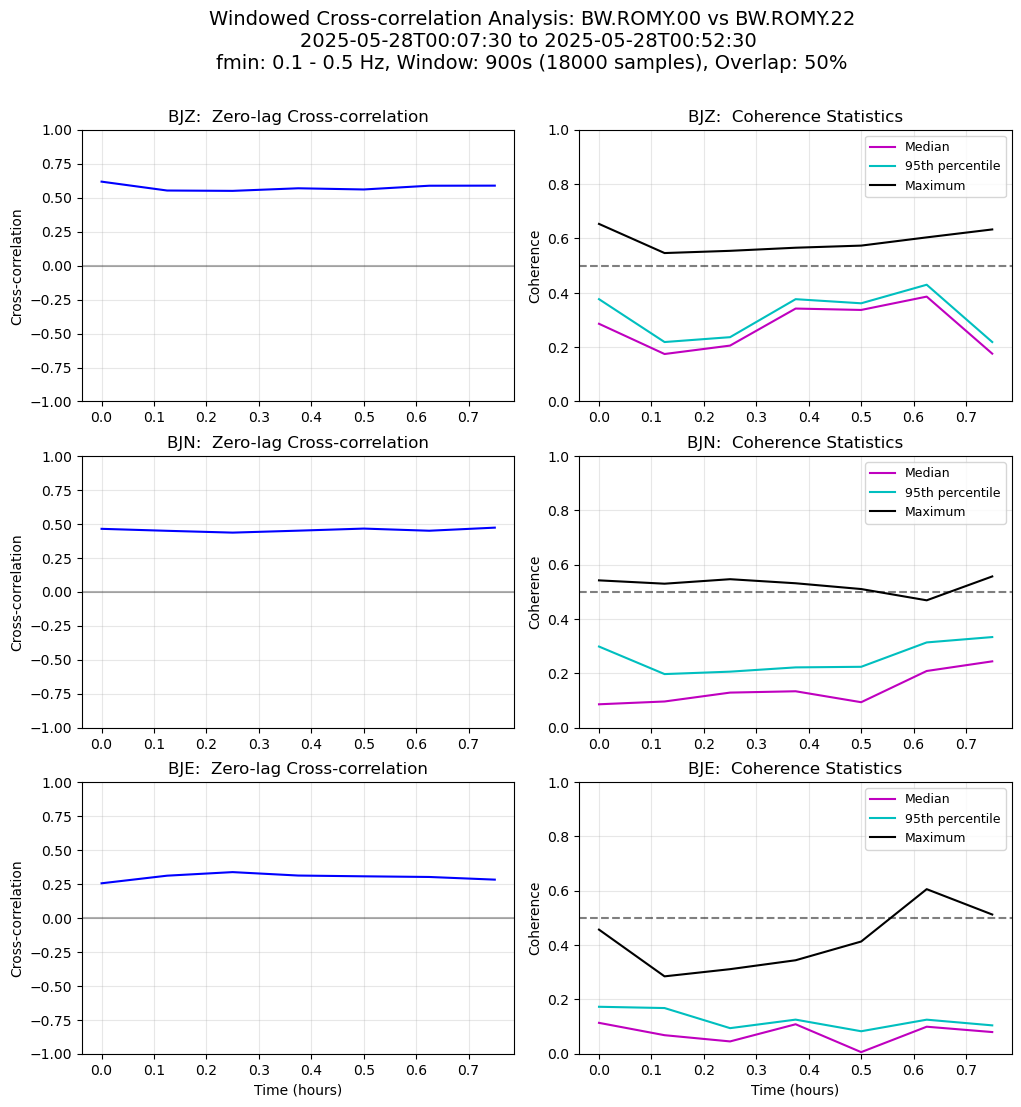

In [ ]:
results, fig_timeseries = __compute_windowed_cross_correlation_analysis(
    st, 
    config['romy_seeds'], 
    config['adr_seeds'],
    twin=config['twin'],  # seconds
    overlap=config['overlap'],  # % overlap
    location_labels=['BW.ROMY.00', 'BW.ROMY.22'],
    tunit=config['time_unit'],
    fmin=config['fmin'],
    fmax=config['fmax']
)

fig_timeseries.savefig(config['path_to_figs']+"makeplot_romy_adr.png")